In [16]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import torch
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.io import decode_image
from torchvision.transforms import Resize
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('medium')

In [17]:
class GlobalStreetscapesSample(Dataset):
    def __init__(self, dataset):
        self.img_labels = dataset
        self.resize = Resize(size=(224, 224))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join("../", self.img_labels.iloc[idx].loc["path"])
        image = decode_image(img_path, apply_exif_orientation=True)
        label = int(self.img_labels.iloc[idx].loc["label"])
        image = self.resize(image)
        return image, label

In [18]:
samples = pd.read_csv('../../data/imgs/sampled.csv', index_col=0)
paths = pd.read_csv('../../data/img_paths.csv', index_col=0)
img_labels = samples.join(paths, on='uuid', how='inner')

print("samples rows:",samples.shape[0])
print("paths rows:",paths.shape[0])
print("img_labels rows:",img_labels.shape[0])

train_ratio = 0.8
train_df, test_df = train_test_split(img_labels, train_size=train_ratio, stratify=img_labels['label'])

display(train_df.head())

training_data = GlobalStreetscapesSample(
    train_df
)

test_data = GlobalStreetscapesSample(
    test_df
)

# Use num_workers for parallel data loading and pin_memory for faster GPU transfer
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)

samples rows: 190693
paths rows: 200660
img_labels rows: 190693


,uuid,source,orig_id,city,country,iso3,s2_cell_id,label,lat,lon,cell_lat,cell_lon,path
165701,2d2690e4-3131-409c-b59f-5ce22b8b9e11,Mapillary,579912700591316,Washington,United States,USA,9923602091161419776,91,38.893125,-77.015232,38.892320,-77.014704,../data/imgs/44558fac-a496-4fd3-8881-4cd2b9c6a...
164226,804109fd-40fe-46c1-97dc-081119f2ac0d,Mapillary,950429422450262,Washington,United States,USA,9923602086598017024,118,38.892093,-77.020597,38.892407,-77.021182,../data/imgs/44558fac-a496-4fd3-8881-4cd2b9c6a...
72603,2eb8ec33-666b-4966-8abe-a887a6f8b82d,Mapillary,156293416508671,Washington,United States,USA,9923602155854364672,19,38.905630,-77.032383,38.905262,-77.032698,../data/imgs/f02e9bd8-5979-42c3-ad55-7b0e460dc...
28793,4446a595-fe3b-4c98-b875-b3e938e82c7f,Mapillary,488250488959645,Washington,United States,USA,9923602086598017024,118,38.892897,-77.021872,38.892407,-77.021182,../data/imgs/4003b889-d68f-4893-b179-6f3b99be0...
58381,9a528118-6ee7-46ce-bb7a-14ee5642d59a,Mapillary,800437937760310,Washington,United States,USA,9923602522805633024,101,38.906247,-77.031852,38.907107,-77.031978,../data/imgs/553e3835-0909-4372-adbc-7af5fb47a...


Washington


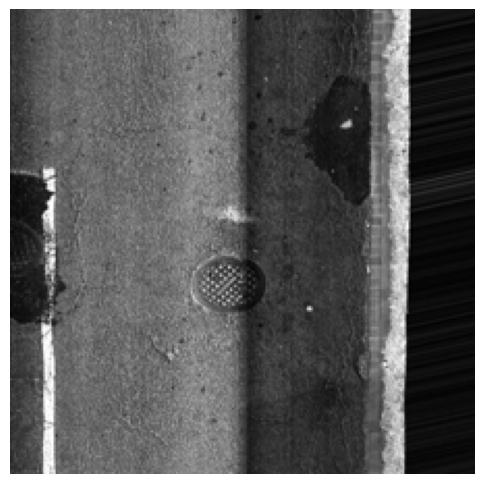

In [19]:
p = os.path.join("../", training_data.img_labels.iloc[10].loc["path"])
print(training_data.img_labels.iloc[10].loc["city"])
img = Image.open(p).convert("RGB")
img = img.resize((224, 224))
plt.figure(figsize=(6,10))
plt.imshow(img)
plt.axis("off")
plt.show()

In [8]:
# Base Vision Transformer Docs: https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py
# VIT_B_16 Docs: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html
weights = ViT_B_16_Weights.IMAGENET1K_V1
transform = weights.transforms()

model = vit_b_16(weights=weights)

in_features = model.heads.head.in_features
num_classes = img_labels.label.nunique()

# Replace the default number of classes
print(f"Previous head: {model.heads.head}")
model.heads.head = torch.nn.Linear(in_features=in_features, out_features=num_classes)
model.num_classes = num_classes
print(f"Previous head: {model.heads.head}")
print(f"Number of classes: {model.num_classes}")

model = model.to(device=device)
print(f"Using device: {device}")

model = torch.compile(model)

Previous head: Linear(in_features=768, out_features=1000, bias=True)
Previous head: Linear(in_features=768, out_features=144, bias=True)
Number of classes: 144
Using device: cuda


In [13]:
start_epoch = 10
num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_loss = 0 if train_loss is None else train_loss
for epoch in range(start_epoch, num_epochs):
    print(f"EPOCH: {epoch+1}")

    current_loss = 0
    model.train()
    for inputs, labels in tqdm(train_dataloader):
        # Move to GPU with non_blocking for better performance
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        inputs = transform(inputs)
        
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        current_loss += loss.item()
    
    avg_train_loss = current_loss / len(train_dataloader)
    train_loss += avg_train_loss
    print(f"Loss: {avg_train_loss:.3f} ({train_loss / (epoch+1):.3f})")
    torch.save(model.state_dict(), f'vit_b_16_base_epoch{epoch}.pth')

EPOCH: 11


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 1.272 (2.442)
EPOCH: 12


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 1.165 (2.336)
EPOCH: 13


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 1.082 (2.239)
EPOCH: 14


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 1.011 (2.151)
EPOCH: 15


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.950 (2.071)
EPOCH: 16


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.892 (1.998)
EPOCH: 17


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.852 (1.930)
EPOCH: 18


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.812 (1.868)
EPOCH: 19


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.778 (1.811)
EPOCH: 20


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.744 (1.757)


In [74]:
METERS_PER_DEG_LAT = 111_000  # ~111 km per degree latitude
METERS_PER_DEG_LON = 86_500   # ~86.5 km per degree longitude at 38.9°N

def euclidean_distance_meters(pred_lat, pred_lon, true_lat, true_lon):
    """
    Calculate approximate Euclidean distance in meters between coordinates.
    Valid for small areas where Earth's curvature is negligible.
    """
    dlat_m = (pred_lat - true_lat) * METERS_PER_DEG_LAT
    dlon_m = (pred_lon - true_lon) * METERS_PER_DEG_LON
    return torch.sqrt(dlat_m**2 + dlon_m**2)

def batch_distance(predicted, actual):
    batch_distance = 0
    
    predicted_latlon = torch.tensor([
        (cell_id_dict[int(label)]['cell_lat'], cell_id_dict[int(label)]['cell_lon'])
        for label in predicted
    ])
    
    labels_latlon = torch.tensor([
        (cell_id_dict[int(label)]['cell_lat'], cell_id_dict[int(label)]['cell_lon'])
        for label in actual
    ])

    for i in range(len(labels_latlon)):
        pred = predicted_latlon[i]
        label = labels_latlon[i]
        distance = euclidean_distance_meters(pred[0], pred[1], label[0], label[1])
        batch_distance += distance
        
    return batch_distance

unique_cell_ids = img_labels[['label', 'cell_lat', 'cell_lon']].drop_duplicates()
cell_id_dict = unique_cell_ids.set_index('label').to_dict(orient='index')

In [75]:
model_path = None
if model_path is not None:
    state_dict = torch.load('vit_b_16_base.pth')
    model = model.load_state_dict(state_dict)
    
model.eval()
test_loss = 0.0
correct = 0
total = 0
total_distance = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        inputs = transform(inputs)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        current_batch_distance = batch_distance(predicted, labels)
        total_distance += current_batch_distance

avg_test_loss = test_loss / len(test_dataloader)
accuracy = 100 * correct / total
avg_distance = total_distance / total

print(f"Test Loss: {avg_test_loss:.3f}")
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Average distance: {avg_distance:.3f} meters")

  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 0.957
Test Accuracy: 77.71%
Average distance: 158.483 meters
